In [1]:
import pandas as pd
import numpy as np
from itertools import product
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl as mpl
from drivermap_utils import (
    get_analysis_df,
    normalize_csif,
    max_attention_window,
    concatenate,
    colorize,
    plot_map_robinson,
    impute_nearby,
    get_attention_weights_df,
)

# Utils

In [2]:
def get_attention_weights_df(index_list, preds):
    df_attention_map = pd.DataFrame(
        columns=[
            "location",
            "hist_tmin",
            "hist_tmax",
            "hist_rad",
            "hist_precip",
            "hist_photo",
            "hist_sm",
        ]
    )
    for index in index_list:
        window_start = max_attention_window(preds, index)
        if window_start <= 335:
            tmin_weight = np.median(
                preds["historical_selection_weights"][
                    index, window_start : window_start + 30, 1
                ]
            )
            tmax_weight = np.median(
                preds["historical_selection_weights"][
                    index, window_start : window_start + 30, 2
                ]
            )
            rad_weight = np.median(
                preds["historical_selection_weights"][
                    index, window_start : window_start + 30, 3
                ]
            )
            precip_weight = np.median(
                preds["historical_selection_weights"][
                    index, window_start : window_start + 30, 4
                ]
            )
            photo_weight = np.median(
                preds["historical_selection_weights"][
                    index, window_start : window_start + 30, 5
                ]
            )  # 5 is photoperiod, 3 is rad
            sm_weight = np.median(
                preds["historical_selection_weights"][
                    index, window_start : window_start + 30, 6
                ]
            )
            location = np.int64(data["data_sets"]["test"]["id"][index][0].split("_")[0])

            new_row = pd.DataFrame(
                {
                    "location": [location],
                    "hist_tmin": [tmin_weight],
                    "hist_tmax": [tmax_weight],
                    "hist_rad": [rad_weight],
                    "hist_precip": [precip_weight],
                    "hist_photo": [photo_weight],
                    "hist_sm": [sm_weight],
                }
            )
            df_attention_map = pd.concat([df_attention_map, new_row], ignore_index=True)

    return df_attention_map


def save_imput_coord_att(index_list, coord_path, output_path):
    df_attention_map = get_attention_weights_df(SOS_indices, preds)
    coords = pd.read_parquet(coord_path)
    coords = coords.drop_duplicates()
    df_coord_att = pd.merge(coords, df_attention_map, on="location", how="left")
    imputed_coord_att = impute_nearby(df_coord_att, 0.5, 0.5)
    imputed_coord_att.to_csv(output_path)

In [25]:
def impute_nearby(df, lat_range=0.5, lon_range=0.5):
    for i, row in df.iterrows():
        if (
            not row[
                [
                    "hist_tmin",
                    "hist_tmax",
                    "hist_rad",
                    "hist_precip",
                    "hist_photo",
                    "hist_sm",
                ]
            ]
            .isnull()
            .all()
        ):
            # Find rows that are close in latitude and longitude and have NaN values
            mask = (
                (df["latitude"] >= row["latitude"] - lat_range)
                & (df["latitude"] <= row["latitude"] + lat_range)
                & (df["longitude"] >= row["longitude"] - lon_range)
                & (df["longitude"] <= row["longitude"] + lon_range)
                & df[
                    [
                        "hist_tmin",
                        "hist_tmax",
                        "hist_rad",
                        "hist_precip",
                        "hist_photo",
                        "hist_sm",
                    ]
                ]
                .isnull()
                .all(axis=1)
            )
            # Impute the NaN values with the current row's values
            df.loc[
                mask,
                [
                    "hist_tmin",
                    "hist_tmax",
                    "hist_rad",
                    "hist_precip",
                    "hist_photo",
                    "hist_sm",
                ],
            ] = row[
                [
                    "hist_tmin",
                    "hist_tmax",
                    "hist_rad",
                    "hist_precip",
                    "hist_photo",
                    "hist_sm",
                ]
            ].values
    return df

In [ ]:
output_path = "code/phenology_analysis/drivers_data/NDT_SOS_july102025.csv"

In [ ]:
PFT = "NDT"
save_imput_coord_att(SOS_indices, coord_path, "code/phenology_analysis/drivers_data/"PFT"_SOS_july102025.csv")
save_imput_coord_att(EOS_indices, coord_path, "code/phenology_analysis/drivers_data/"PFT"_EOS_july102025.csv")

In [ ]:
!ls "/burg/home/al4385/code/phenology_analysis/drivers_data/"

In [ ]:
BET = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BET_20250714_SOS.csv"
)
# NET = pd.read_csv("/burg/home/al4385/code/phenology_analysis/drivers_data/NET_20250714_SOS.csv")
# BDT2020 = pd.read_csv("/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_-20_20_20250714_EOS.csv")
# BDT2020 = pd.read_csv("/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_-20_20_20250714_SOS.csv")

In [ ]:
BET[1:2][
    ["hist_tmin", "hist_tmax", "hist_rad", "hist_precip", "hist_photo", "hist_sm"]
].isnull().all() == True

In [ ]:
BET = BET[BET["latitude"] < 30]
# NET = NET[NET['latitude']<75]

In [ ]:
full = concatenate([BET])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "sos")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


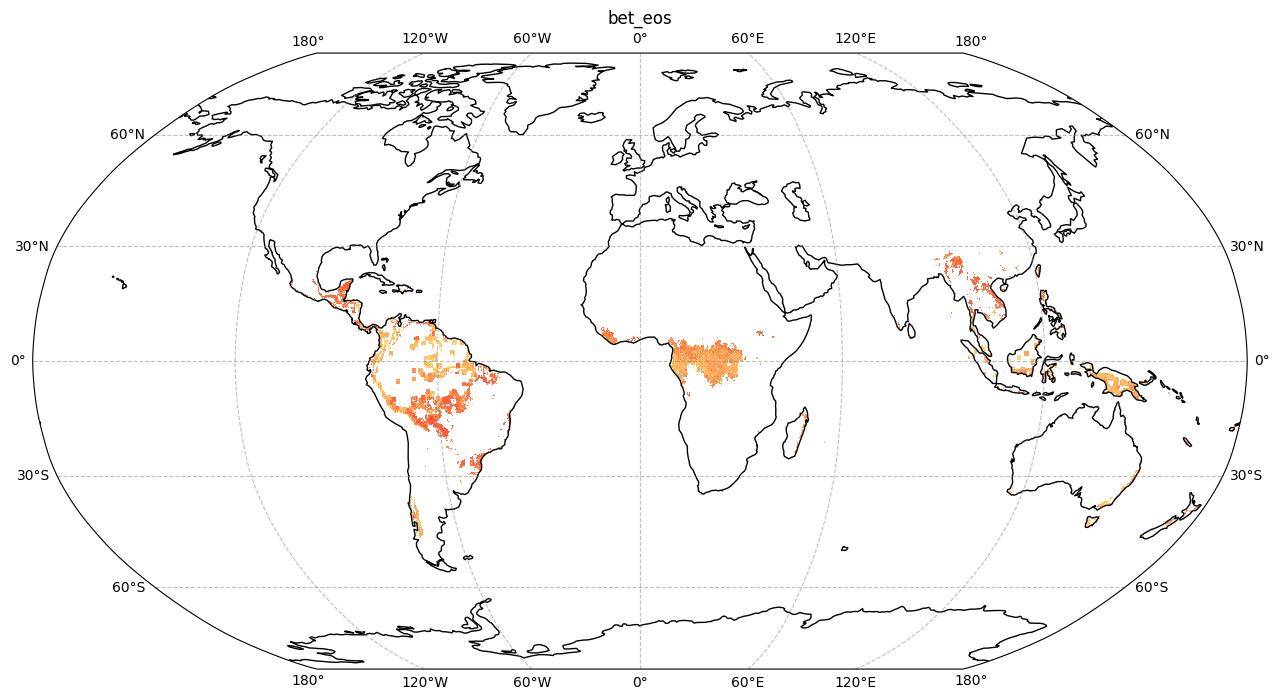

In [3]:
BET_EOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BET_20250714_EOS.csv"
)
BET_EOS = BET_EOS[BET_EOS["latitude"] < 30]
full = concatenate([BET_EOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "bet_eos")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


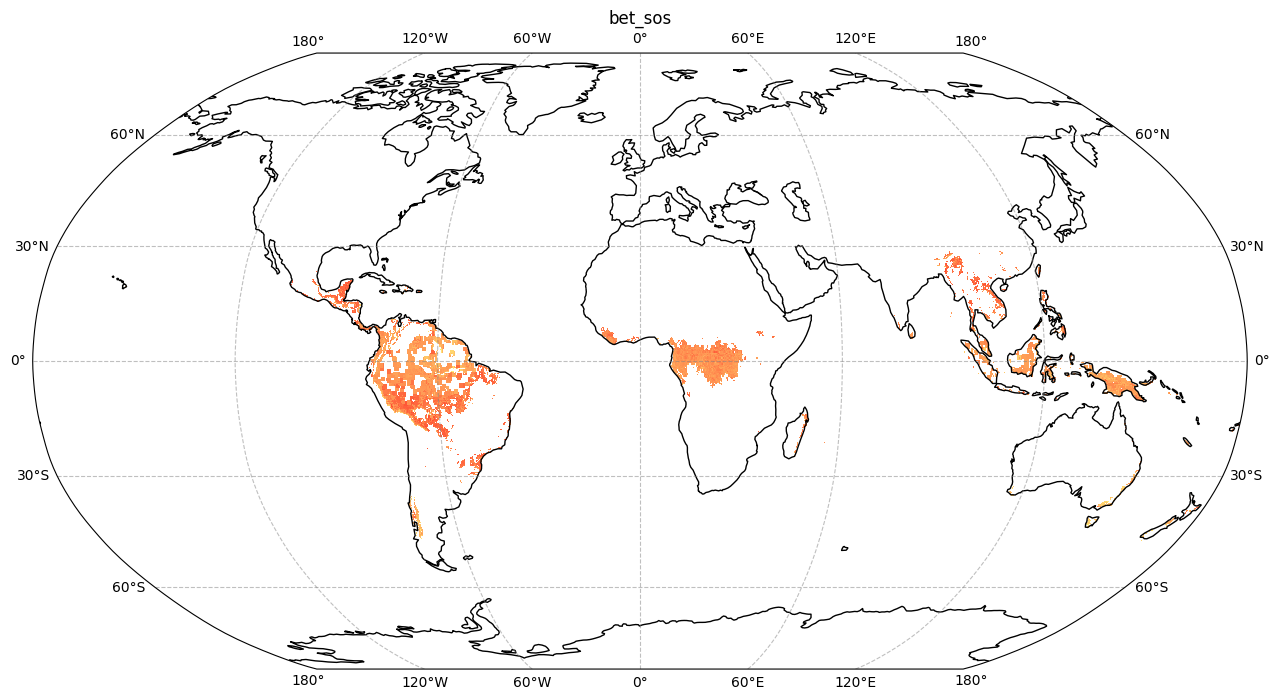

In [4]:
BET_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BET_20250714_SOS.csv"
)
BET_SOS = BET_SOS[BET_SOS["latitude"] < 30]
full = concatenate([BET_SOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "bet_sos")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


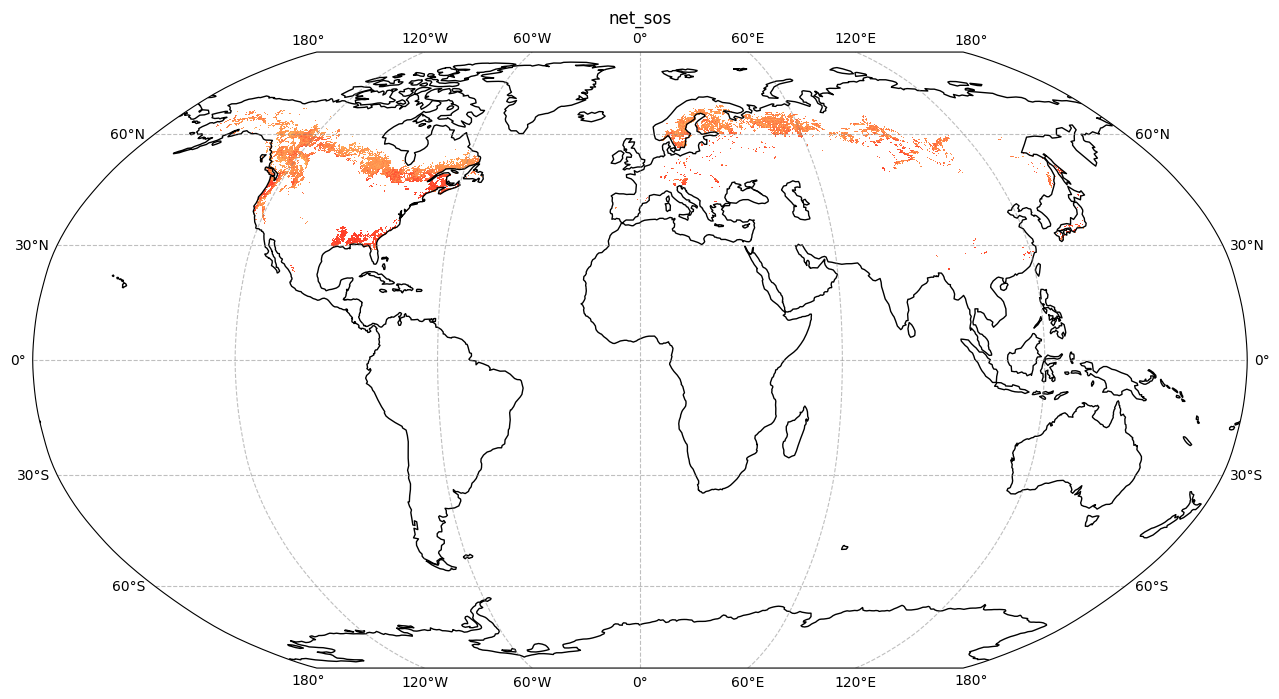

In [5]:
NET_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/NET_20250714_SOS.csv"
)
NET_SOS = NET_SOS[NET_SOS["latitude"] < 75]
full = concatenate([NET_SOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "net_sos")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


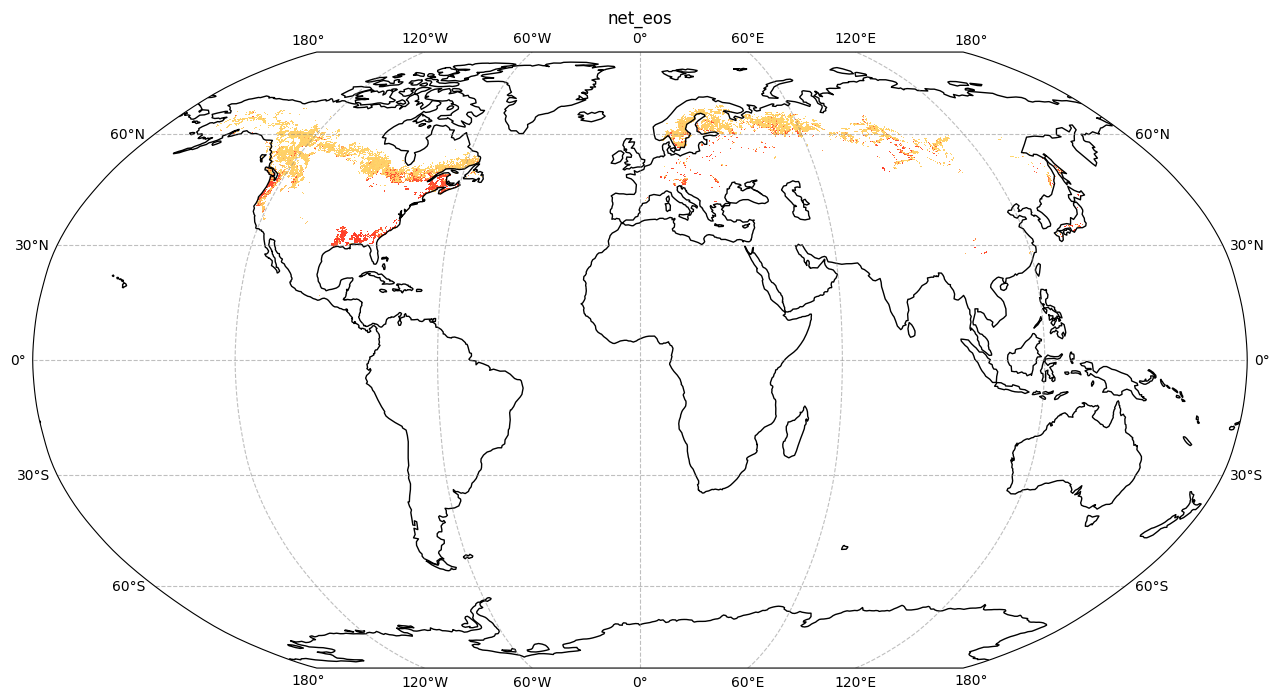

In [30]:
NET_EOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/NET_20250714_EOS.csv"
)
NET_EOS = NET_EOS[NET_EOS["latitude"] < 75]
full = concatenate([NET_EOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "net_eos")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


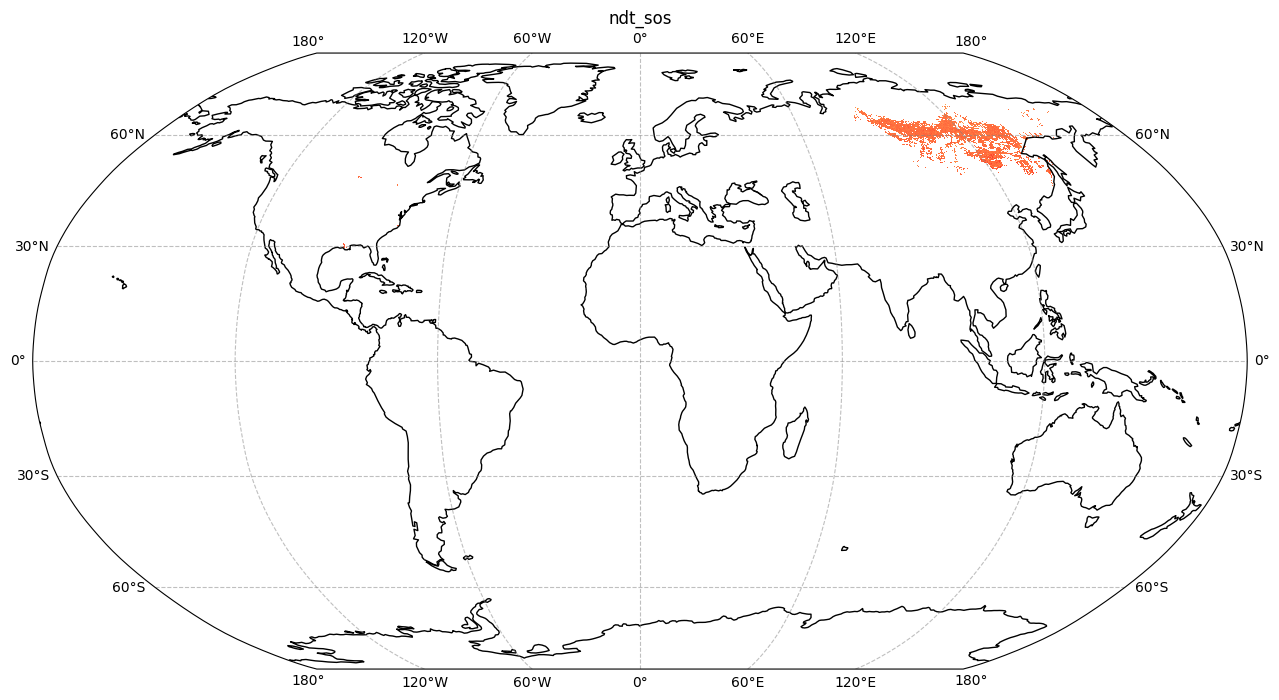

In [2]:
NDT_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/NDT_20250714_SOS.csv"
)
NDT_SOS = NDT_SOS[NDT_SOS["latitude"] < 75]
full = concatenate([NDT_SOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "ndt_sos")

In [2]:
def plot_map_robinson(rgb_list, output_path, title=None):
    # Ensure the rgb_list contains exactly 3 elements (R, G, B channels)
    if len(rgb_list) != 3:
        raise ValueError(
            "rgb_list must contain exactly 3 elements corresponding to R, G, B channels."
        )

    # Stack the RGB channels along the last axis to form an RGB image
    rgb_data = np.stack(rgb_list, axis=-1)

    # Verify the shape of the RGB data (should be 2D grid with 3 color channels)
    if rgb_data.ndim != 3 or rgb_data.shape[-1] != 3:
        raise ValueError("Stacked RGB data should have a shape of (height, width, 3).")

    # Define latitude and longitude values for ticks
    latitudes = np.linspace(90.0, -90.0, rgb_data.shape[0])  # Match the grid shape
    longitudes = np.linspace(-180.0, 180.0, rgb_data.shape[1])  # Match the grid shape

    # Create a new figure and plot
    plt.figure(figsize=(16, 8))

    # Create a Cartopy projection using Robinson projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot coastlines for reference
    ax.coastlines()

    # Add gridlines
    ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)
    if title is not None:
        plt.title(title)
    # Plot the RGB data using the `transform` argument for the PlateCarree projection
    plt.imshow(
        rgb_data,
        extent=[-180, 180, -90, 90],
        origin="upper",
        transform=ccrs.PlateCarree(),
        interpolation="none",
    )

    # Display the plot
    # plt.savefig(output_path+title+".png")
    plt.show()


# plot_map_robinson(rgb_list,  output_path,  'ndt_sos')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1524502169520743..255.0].


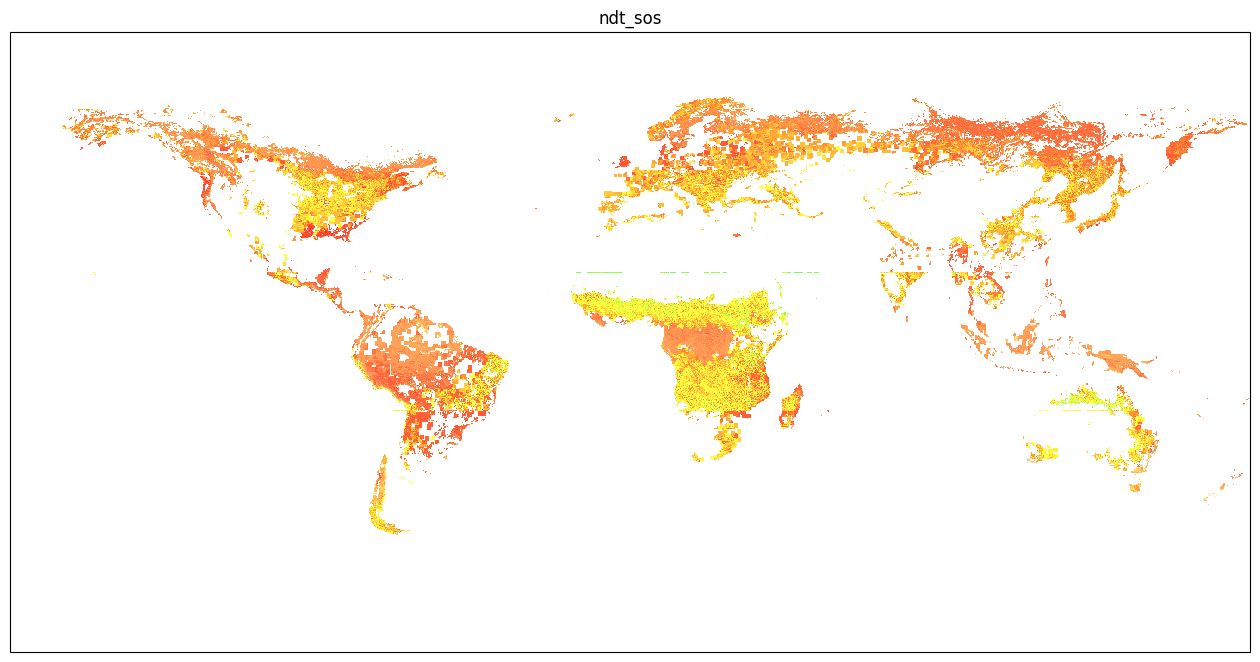

In [43]:
def plot_map_robinson(rgb_list, output_path, title=None, crop_extent=None):
    # … your existing stacking/code …

    fig = plt.figure(figsize=(16, 12))
    ax = plt.axes(projection=ccrs.EqualEarth())
    ax.coastlines()

    # ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)

    if crop_extent is not None:
        crop_extent = crop_extent
        ax.set_extent(crop_extent, crs=ccrs.EqualEarth())
        ax.set_axis_off()

    if title:
        plt.title(title)
    rgb_data = np.stack(rgb_list, axis=-1)
    plt.imshow(
        rgb_data,
        extent=[-180, 180, -90, 90],
        origin="upper",
        transform=ccrs.EqualEarth(),
        interpolation="none",
    )

    plt.show()


# only show North America
crop = [-169, 180, -60, 75]
plot_map_robinson(rgb_list, output_path, "ndt_sos", crop_extent=None)

In [ ]:
cartopy.feature.NaturalEarthFeature

In [ ]:
# Ensure the rgb_list contains exactly 3 elements (R, G, B channels)
    if len(rgb_list) != 3:
        raise ValueError("rgb_list must contain exactly 3 elements corresponding to R, G, B channels.")

    # Stack the RGB channels along the last axis to form an RGB image
    rgb_data = np.stack(rgb_list, axis=-1)

    # Verify the shape of the RGB data (should be 2D grid with 3 color channels)
    if rgb_data.ndim != 3 or rgb_data.shape[-1] != 3:
        raise ValueError("Stacked RGB data should have a shape of (height, width, 3).")

    # Define latitude and longitude values for ticks
    latitudes = np.linspace(90.0, -90.0, rgb_data.shape[0])  # Match the grid shape
    longitudes = np.linspace(-180.0, 180.0, rgb_data.shape[1])  # Match the grid shape

    # Create a new figure and plot
    plt.figure(figsize=(16, 8))

    # Create a Cartopy projection using Robinson projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot coastlines for reference
    ax.coastlines()

    # Add gridlines
    ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
    if title is not None:
        plt.title(title)
    # Plot the RGB data using the `transform` argument for the PlateCarree projection
    plt.imshow(rgb_data, extent=[-180, 180, -90, 90], origin='upper', transform=ccrs.PlateCarree(), interpolation='none')

    # Display the plot
    #plt.savefig(output_path+title+".png")
    plt.show()
#plot_map_robinson(rgb_list,  output_path,  'ndt_sos')

In [ ]:
import plotly.express as px

df_ter = full[["hist_temp", "hist_sol", "hist_p"]]
fig = px.scatter_ternary(df_ter, a="hist_temp", b="hist_sol", c="hist_p")
fig.show()

In [ ]:
import plotly.figure_factory as ff
import numpy as np

Al = np.array([0.0, 0.0, 0.0, 0.0, 1.0 / 3, 1.0 / 3, 1.0 / 3, 2.0 / 3, 2.0 / 3, 1.0])
Cu = np.array([0.0, 1.0 / 3, 2.0 / 3, 1.0, 0.0, 1.0 / 3, 2.0 / 3, 0.0, 1.0 / 3, 0.0])
Y = 1 - Al - Cu
# synthetic data for mixing enthalpy
# See https://pycalphad.org/docs/latest/examples/TernaryExamples.html
enthalpy = (Al - 0.01) * Cu * (Al - 0.52) * (Cu - 0.48) * (Y - 1) ** 2
fig = ff.create_ternary_contour(
    np.array([hist_temp, hist_sol, hist_p]),
    enthalpy,
    pole_labels=["T", "R", "W"],
    interp_mode="cartesian",
)
fig.show()

In [79]:
full

latitude  longitude  Unnamed: 0  location  hist_tmin  hist_tmax  \
0           90.00    -180.00         NaN       NaN        NaN        NaN   
1           90.00    -179.75         NaN       NaN        NaN        NaN   
2           90.00    -179.50         NaN       NaN        NaN        NaN   
3           90.00    -179.25         NaN       NaN        NaN        NaN   
4           90.00    -179.00         NaN       NaN        NaN        NaN   
...           ...        ...         ...       ...        ...        ...   
1036795    -89.75     178.75         NaN       NaN        NaN        NaN   
1036796    -89.75     179.00         NaN       NaN        NaN        NaN   
1036797    -89.75     179.25         NaN       NaN        NaN        NaN   
1036798    -89.75     179.50         NaN       NaN        NaN        NaN   
1036799    -89.75     179.75         NaN       NaN        NaN        NaN   

         hist_rad  hist_precip  hist_photo  hist_sm  hist_temp  hist_sol  \
0             NaN          NaN         NaN      NaN        NaN       NaN   
1             NaN          NaN         NaN      NaN        NaN       NaN   
2             NaN          NaN         NaN      NaN        NaN       NaN   
3             NaN          NaN         NaN      NaN        NaN       NaN   
4             NaN          NaN         NaN      NaN        NaN       NaN   
...           ...          ...         ...      ...        ...       ...   
1036795       NaN          NaN         NaN      NaN        NaN       NaN   
1036796       NaN          NaN         NaN      NaN        NaN       NaN   
1036797       NaN          NaN         NaN      NaN        NaN       NaN   
1036798       NaN          NaN         NaN      NaN        NaN       NaN   
1036799       NaN          NaN         NaN      NaN        NaN       NaN   

         hist_p  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
1036795     NaN  
1036796     NaN  
1036797     NaN  
1036798     NaN  
1036799     NaN  

[1036800 rows x 13 columns]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1524502169520743..255.0].


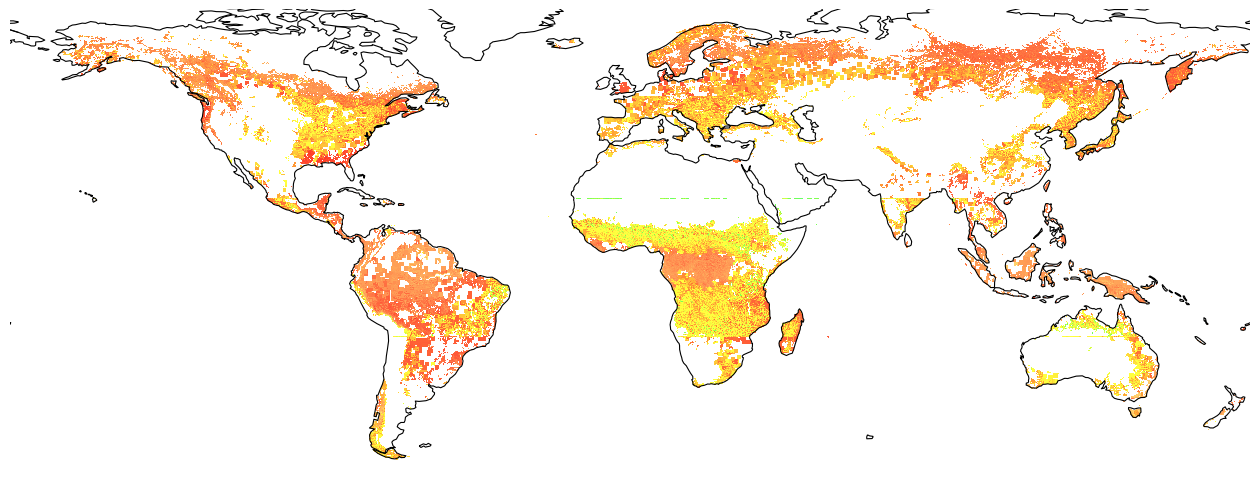

In [78]:
import cartopy.feature as cfeature

fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
ax.coastlines(resolution="110m", color="k", linewidth=0.8)

crop_extent = [-180, 180, -60, 75]
ax.set_extent(crop_extent, crs=ccrs.PlateCarree())
ax.set_axis_off()
# ax.add_feature(NaturalEarthFeature.COASTLINE) color='black'


rgb_data = np.stack(rgb_list, axis=-1)
plt.imshow(
    rgb_data,
    extent=[-180, 180, -90, 90],
    origin="upper",
    transform=ccrs.PlateCarree(),
    interpolation="none",
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


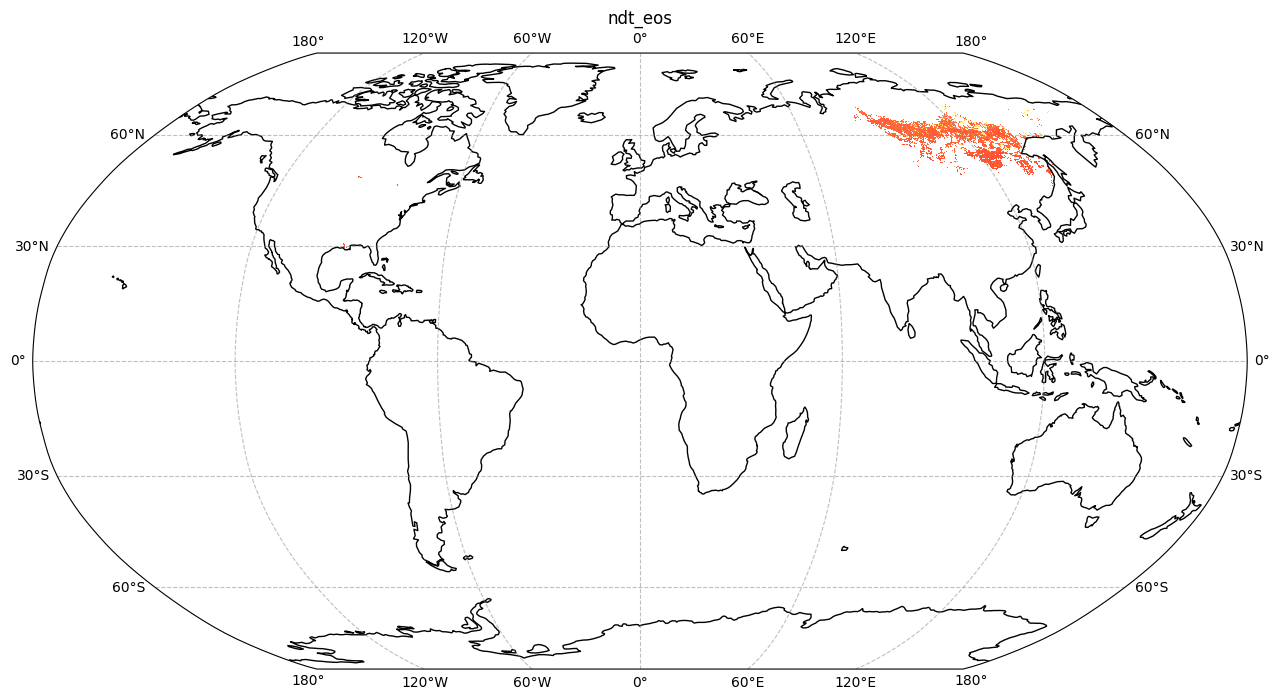

In [10]:
NDT_EOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/NDT_20250714_EOS.csv"
)
NDT_EOS = NDT_EOS[NDT_EOS["latitude"] < 75]
full = concatenate([NDT_EOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "ndt_eos")

In [2]:
!ls "/burg/home/al4385/code/phenology_analysis/drivers_data/"

BDT_-20_20_20250714_EOS.csv   BDT_50_20_20250716_SOS.csv  bet_eos.png
BDT_-20_20_20250714_SOS.csv   BDT_5020_EOS.png		  bet_sos.png
BDT_-20_20_20250716_EOS.csv   BDT_50_90_20250714_EOS.csv  NDT_20250714_EOS.csv
BDT_-20_20_20250716_SOS.csv   BDT_50_90_20250714_SOS.csv  NDT_20250714_SOS.csv
BDT_2020_EOS.png	      BDT_50_90_20250716_EOS.csv  ndt_eos.png
BDT_-20_-60_20250714_EOS.csv  BDT_50_90_20250716_SOS.csv  ndt_sos.png
BDT_-20_-60_20250714_SOS.csv  BDT_EOS.png		  NET_20250714_EOS.csv
BDT_-20_-60_20250716_EOS.csv  BET_20250714_EOS.csv	  NET_20250714_SOS.csv
BDT_-20_-60_20250716_SOS.csv  BET_20250714_SOS.csv	  net_eos.png
BDT_2060_EOS.png	      BET_20250715_EOS.csv	  net_sos.png
BDT_50_20_20250714_EOS.csv    BET_20250715_SOS.csv	  sos.png
BDT_50_20_20250714_SOS.csv    BET_20250716_EOS.csv
BDT_50_20_20250716_EOS.csv    BET_20250716_SOS.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


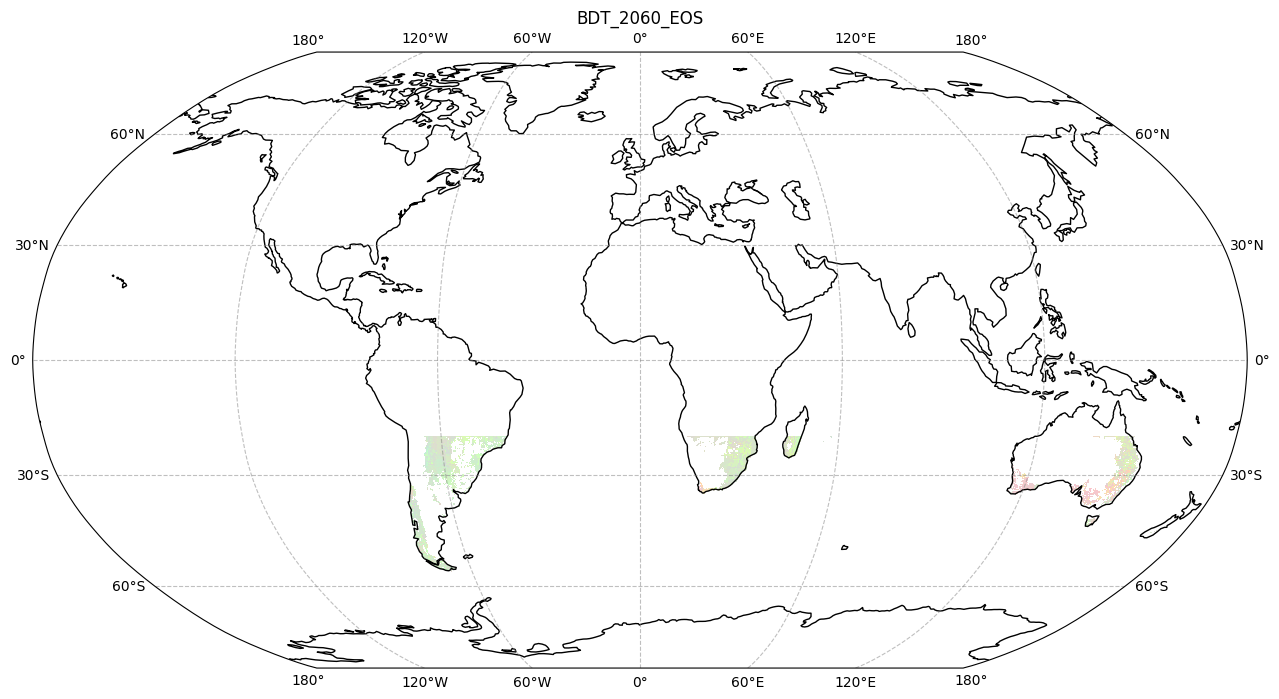

In [14]:
BDT_2060_EOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_-20_-60_20250714_EOS.csv"
)
BDT_2060_EOS = BDT_2060_EOS[BDT_2060_EOS["latitude"] < 75]
full = concatenate([BDT_2060_EOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_2060_EOS")

In [23]:
BDT_2020_EOS[
    ["hist_tmin", "hist_tmax", "hist_rad", "hist_precip", "hist_photo", "hist_sm"]
].describe()

hist_tmin      hist_tmax       hist_rad    hist_precip  \
count  111296.000000  111296.000000  111296.000000  111296.000000   
mean        0.031157       0.047415       0.049569       0.047427   
std         0.010507       0.041100       0.039435       0.033097   
min         0.021729       0.014735       0.016971       0.014042   
25%         0.022383       0.018374       0.020942       0.020027   
50%         0.026008       0.029292       0.032329       0.033032   
75%         0.038734       0.063422       0.066374       0.069648   
max         0.065358       0.304101       0.277216       0.162381   

          hist_photo        hist_sm  
count  111296.000000  111296.000000  
mean        0.062832       0.044671  
std         0.005241       0.025158  
min         0.056526       0.019687  
25%         0.058324       0.023440  
50%         0.061756       0.033803  
75%         0.065932       0.062270  
max         0.080469       0.128080

In [24]:
BDT_2060_EOS[
    ["hist_tmin", "hist_tmax", "hist_rad", "hist_precip", "hist_photo", "hist_sm"]
].describe()

hist_tmin     hist_tmax      hist_rad   hist_precip    hist_photo  \
count  30108.000000  30108.000000  30108.000000  30108.000000  30108.000000   
mean       0.042363      0.025104      0.030183      0.038275      0.047929   
std        0.004891      0.002602      0.003602      0.002837      0.002412   
min        0.024204      0.019527      0.021725      0.031372      0.041234   
25%        0.039807      0.023443      0.027621      0.036152      0.046667   
50%        0.042765      0.024830      0.029702      0.038174      0.048256   
75%        0.045077      0.026094      0.032784      0.040183      0.049542   
max        0.063170      0.037892      0.039207      0.048725      0.057787   

            hist_sm  
count  30108.000000  
mean       0.034370  
std        0.002453  
min        0.028265  
25%        0.032747  
50%        0.033951  
75%        0.035541  
max        0.043856

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


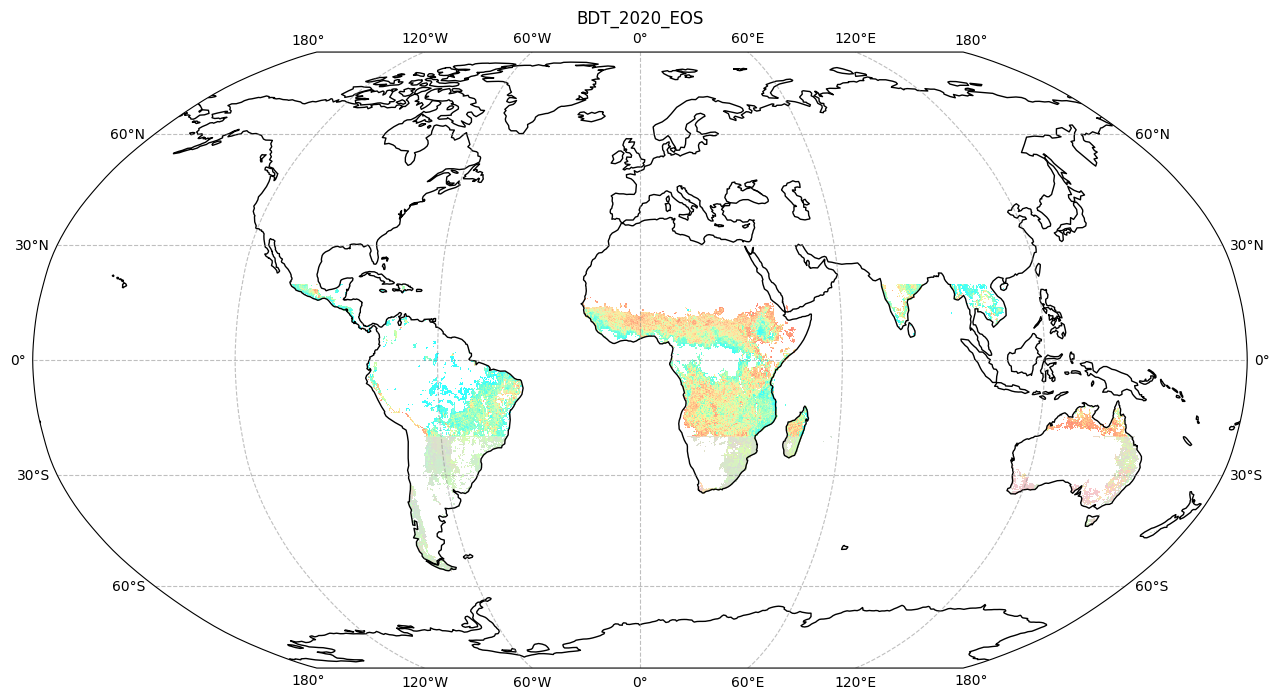

In [15]:
full = concatenate([BDT_2020_EOS, BDT_2060_EOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_2020_EOS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


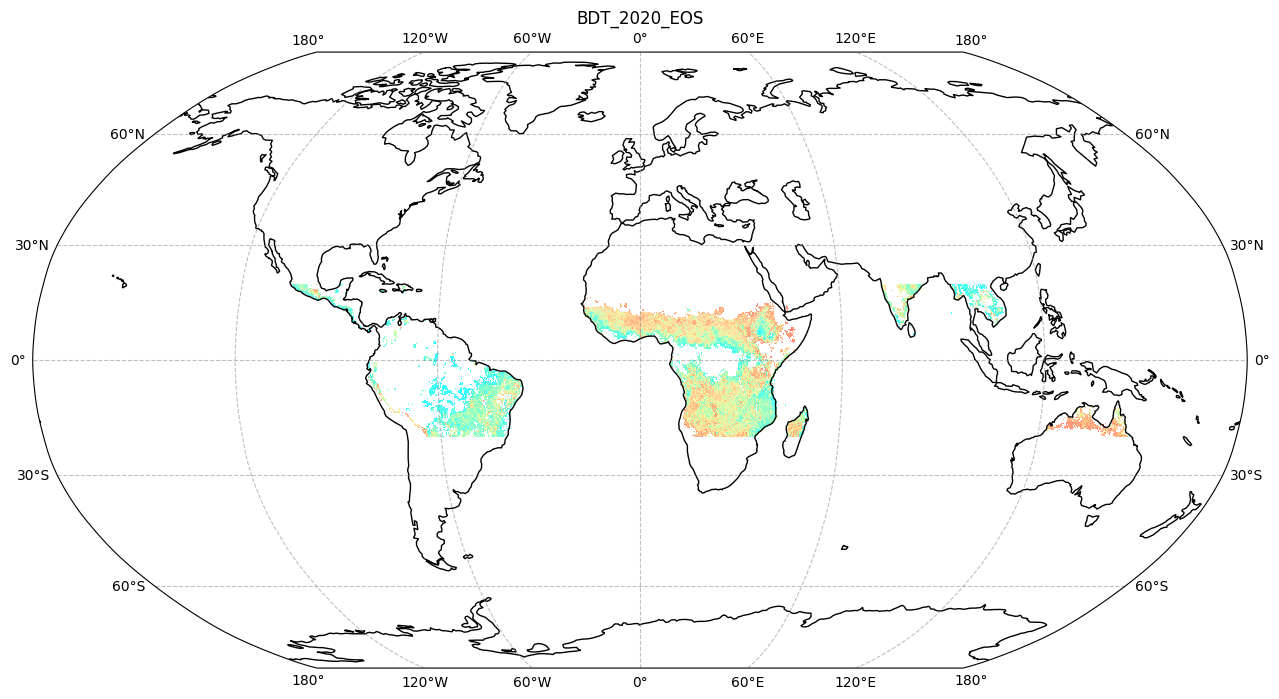

In [13]:
BDT_2020_EOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_-20_20_20250714_EOS.csv"
)
BDT_2020_EOS = BDT_2020_EOS[BDT_2020_EOS["latitude"] < 75]
full = concatenate([BDT_2020_EOS, BDT_2060_EOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_2020_EOS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


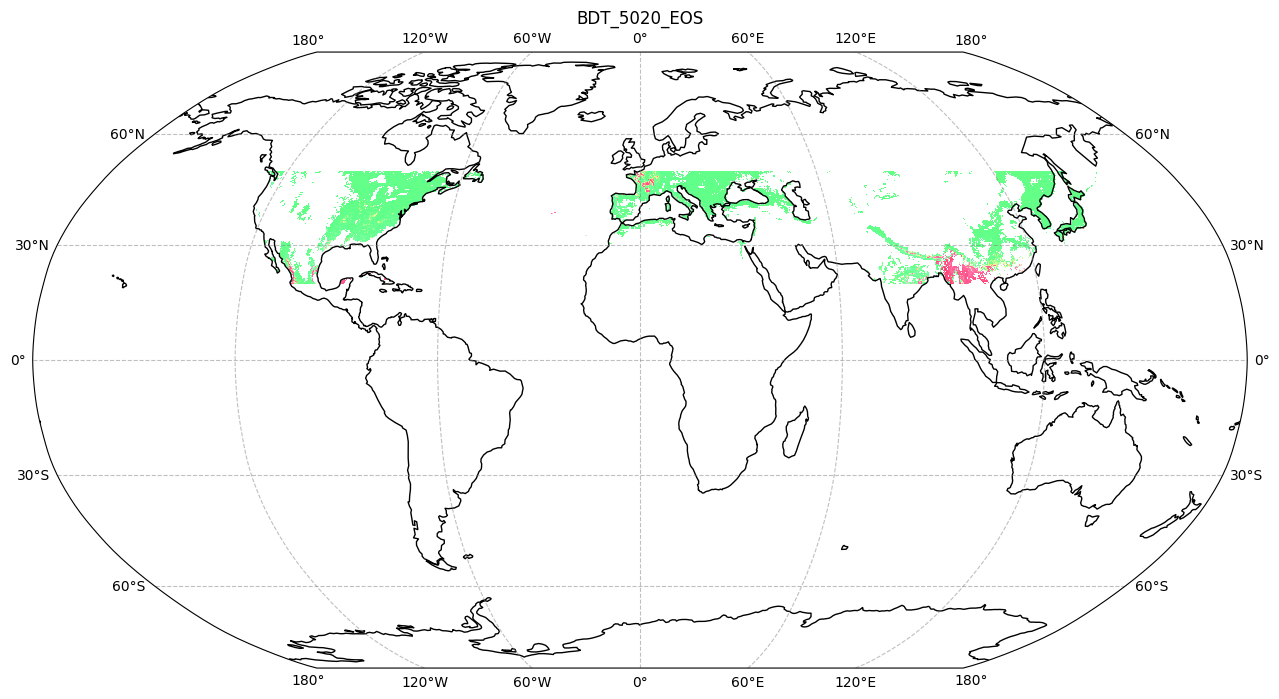

In [26]:
BDT_5020_EOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_50_20_20250714_EOS.csv"
)
BDT_5020_EOS = BDT_5020_EOS[BDT_5020_EOS["latitude"] < 50]
full = concatenate([BDT_5020_EOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_5020_EOS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


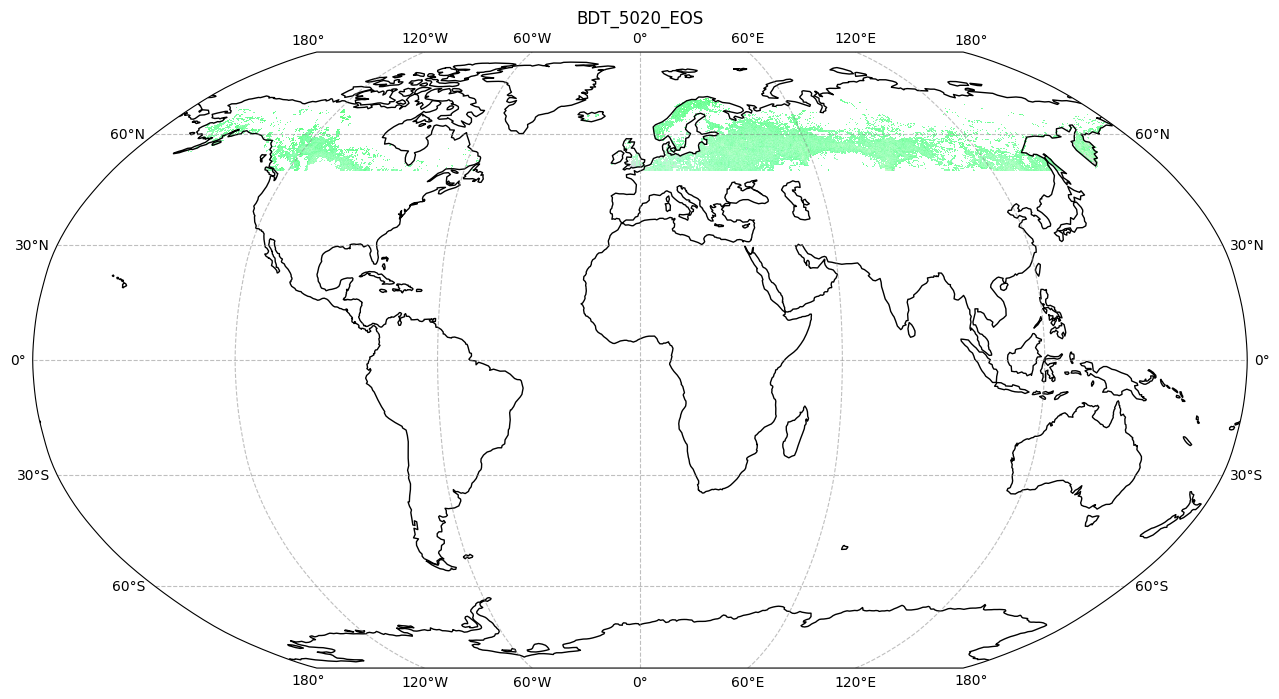

In [27]:
BDT_5090_EOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_50_90_20250714_EOS.csv"
)
BDT_5090_EOS = BDT_5090_EOS[BDT_5090_EOS["latitude"] < 75]
full = concatenate([BDT_5090_EOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_5020_EOS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


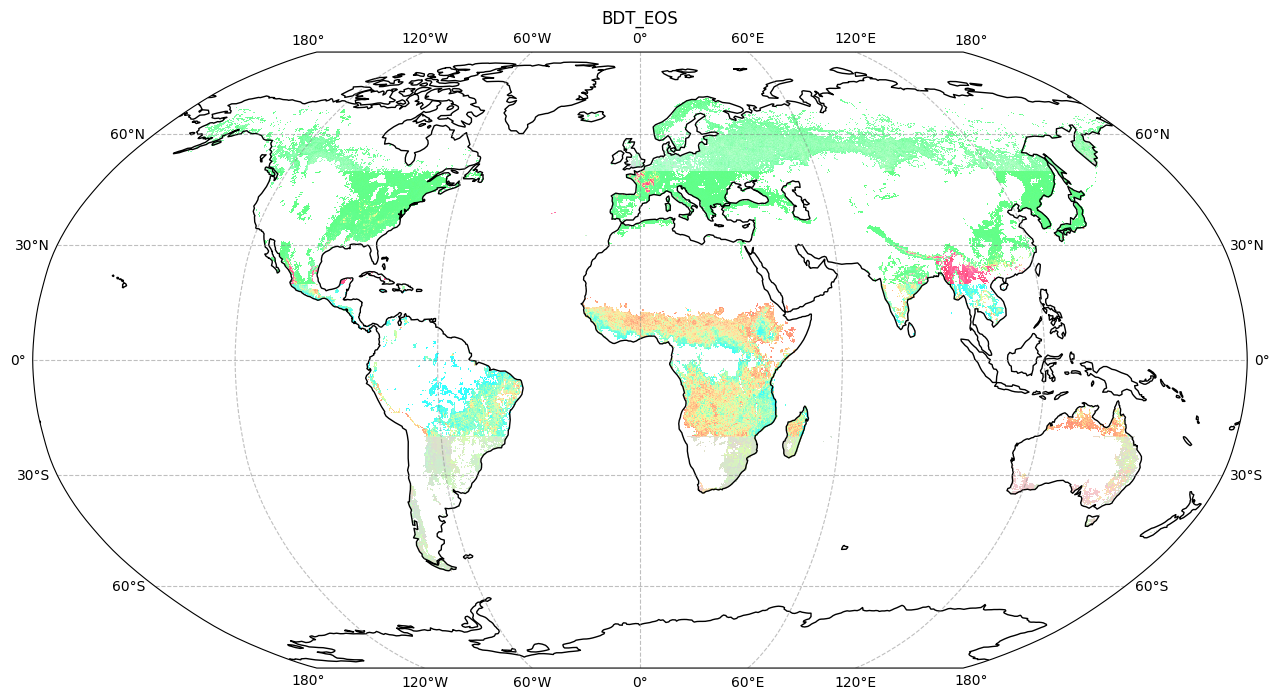

In [28]:
full = concatenate([BDT_5090_EOS, BDT_5020_EOS, BDT_2020_EOS, BDT_2060_EOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_EOS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


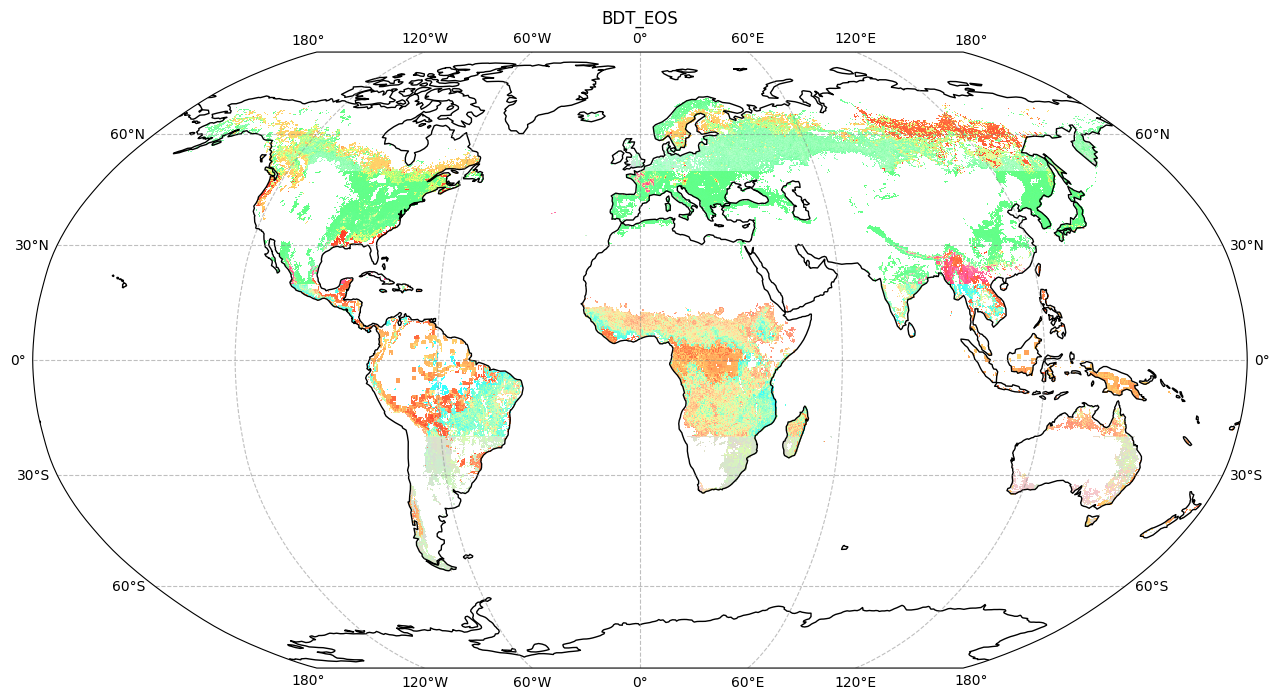

In [32]:
full = concatenate(
    [BET_EOS, NET_EOS, NDT_EOS, BDT_5090_EOS, BDT_5020_EOS, BDT_2020_EOS, BDT_2060_EOS]
)
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_EOS")

In [2]:
!ls /burg/home/al4385/code/phenology_analysis/drivers_data/

BDT_-20_20_20250714_EOS.csv   BDT_50_20_20250716_EOS.csv  bet_eos.png
BDT_-20_20_20250714_SOS.csv   BDT_50_20_20250716_SOS.csv  bet_sos.png
BDT_-20_20_20250716_EOS.csv   BDT_5020_EOS.png		  NDT_20250714_EOS.csv
BDT_-20_20_20250716_SOS.csv   BDT_50_90_20250714_EOS.csv  NDT_20250714_SOS.csv
BDT_2020_EOS.png	      BDT_50_90_20250714_SOS.csv  ndt_eos.png
BDT_-20_-60_20250714_EOS.csv  BDT_50_90_20250716_EOS.csv  ndt_sos.png
BDT_-20_-60_20250714_SOS.csv  BDT_50_90_20250716_SOS.csv  NET_20250714_EOS.csv
BDT_-20_-60_20250716_EOS.csv  BDT_EOS.png		  NET_20250714_SOS.csv
BDT_-20_-60_20250716_SOS.csv  BET_20250714_EOS.csv	  net_eos.png
BDT_2060_EOS.png	      BET_20250714_SOS.csv	  net_sos.png
BDT_50_20_20250714_EOS.csv    BET_20250715_EOS.csv	  sos.png
BDT_50_20_20250714_SOS.csv    BET_20250715_SOS.csv


In [14]:
### Get SOS Map
BDT_5020_SOS = pd.read_csv(
    "/burg-archive/home/al4385/code/phenology_analysis/drivers_data/BDT_50_20_20250718_SOS.csv"
)
BDT_5020_SOS = BDT_5020_SOS[BDT_5020_SOS["latitude"] < 50]
BDT_5020_SOS = BDT_5020_SOS[BDT_5020_SOS["latitude"] > 20]

BDT_2020_SOS = pd.read_csv(
    "/burg-archive/home/al4385/code/phenology_analysis/drivers_data/BDT_-20_20_20250718_SOS.csv"
)
BDT_2060_SOS = BDT_2060_SOS[BDT_2060_SOS["latitude"] < 20]

BDT_2060_SOS = pd.read_csv(
    "/burg-archive/home/al4385/code/phenology_analysis/drivers_data/BDT_-20_-60_20250718_SOS.csv"
)
BDT_2060_SOS = BDT_2060_SOS[BDT_2060_SOS["latitude"] < -20]


BDT_5090_SOS = pd.read_csv(
    "/burg-archive/home/al4385/code/phenology_analysis/drivers_data/BDT_50_90_20250718_SOS.csv"
)
BDT_5020_SOS = BDT_5020_SOS[BDT_5020_SOS["latitude"] < 75]

BET_SOS = pd.read_csv(
    "/burg-archive/home/al4385/code/phenology_analysis/drivers_data/BET_20250718_SOS.csv"
)
BET_SOS = BET_SOS[BET_SOS["latitude"] < 30]

NDT_SOS = pd.read_csv(
    "/burg-archive/home/al4385/code/phenology_analysis/drivers_data/NDT_20250714_SOS.csv"
)
NDT_SOS = NDT_SOS[NDT_SOS["latitude"] < 75]

NET_SOS = pd.read_csv(
    "/burg-archive/home/al4385/code/phenology_analysis/drivers_data/NET_20250714_SOS.csv"
)
NET_SOS = NET_SOS[NET_SOS["latitude"] < 75]

In [12]:
def plot_map(rgb_list, output_path, title=None, crop_extent=None):
    # … your existing stacking/code …

    fig = plt.figure(figsize=(16, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    # ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)

    if crop_extent is not None:
        crop_extent = crop_extent
        ax.set_extent(crop_extent, crs=ccrs.PlateCarree())
        ax.set_axis_off()

    if title:
        plt.title(title)
    rgb_data = np.stack(rgb_list, axis=-1)
    plt.imshow(
        rgb_data,
        extent=[-180, 180, -90, 90],
        origin="upper",
        transform=ccrs.PlateCarree(),
        interpolation="none",
    )

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21011600678758402..255.0].


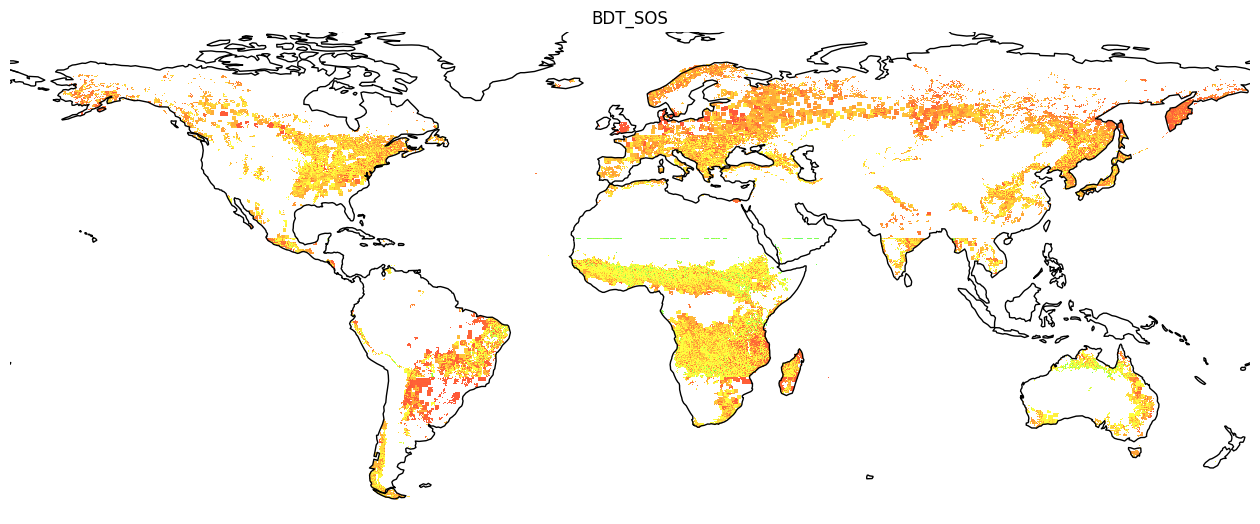

In [17]:
full = concatenate([BDT_5020_SOS, BDT_2020_SOS, BDT_2060_SOS, BDT_5090_SOS])
rgb_list = colorize(full)
plot_map(rgb_list, output_path, "BDT_SOS", [-180, 180, -60, 80])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21011600678758402..255.0].


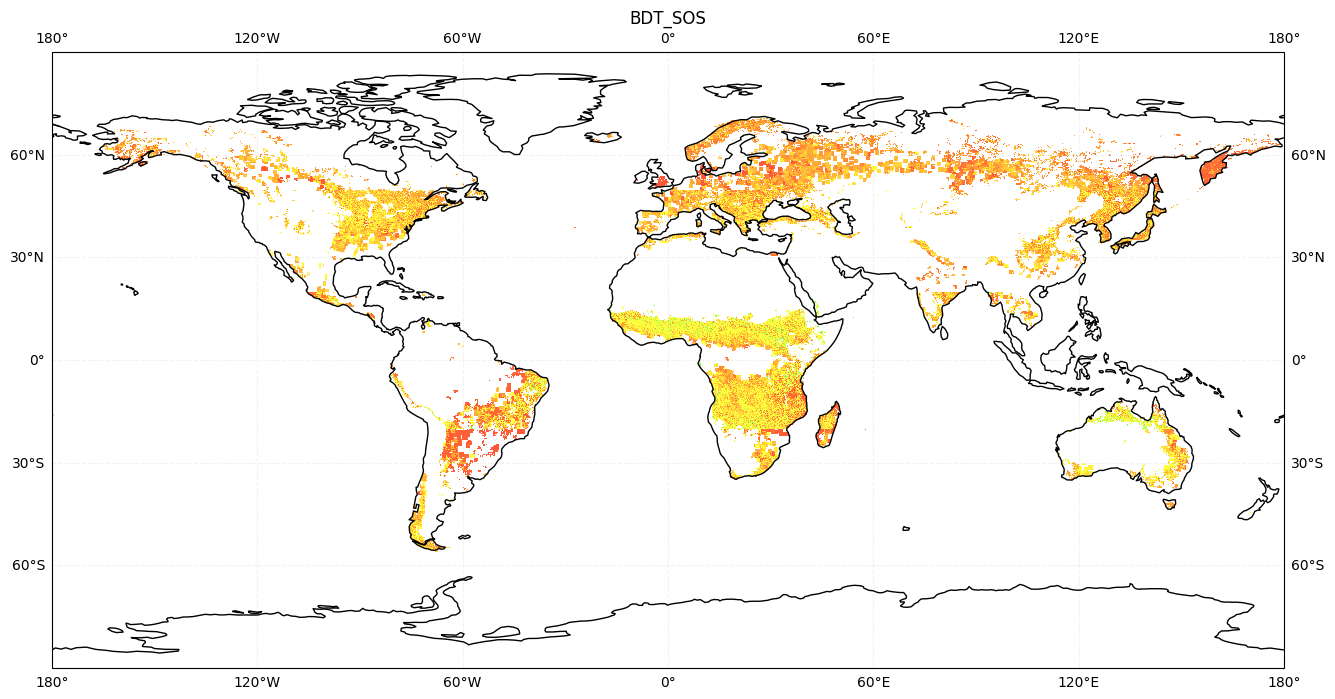

In [21]:
full = concatenate([BDT_5020_SOS, BDT_2020_SOS, BDT_2060_SOS, BDT_5090_SOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_SOS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21011600678758402..255.0].


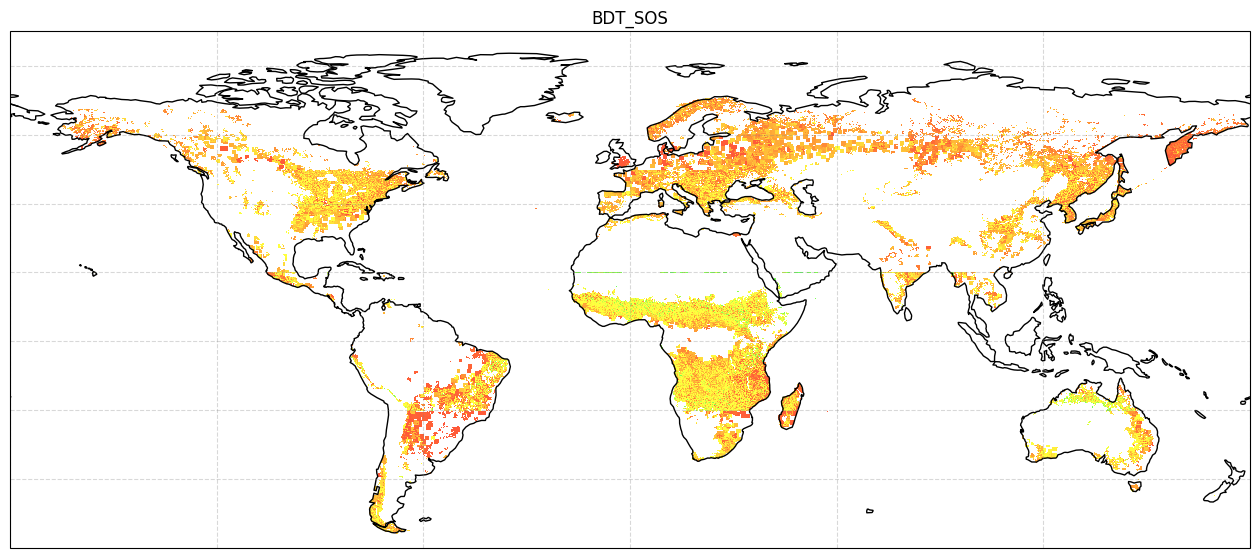

In [65]:
def plot_map_rgb(
    rgb_list,
    output_path,
    title=None,
    projection="Robinson",  # "Robinson" or "PlateCarree"
    crop_lat=-60,  # hide Antarctica by default
    draw_coastlines=True,
    draw_gridlines=True,
    save=True,
    show=True,
    dpi=300,
):
    """
    Plot an RGB image (R,G,B arrays) on a map with robust handling of reprojection artifacts.
    - Adds a cyclic column at the antimeridian
    - Masks (alpha) latitudes below crop_lat to prevent resampling speckles
    - Optionally crops the map view after drawing
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    from cartopy.util import add_cyclic_point

    # ---- Validate & stack ----
    if len(rgb_list) != 3:
        raise ValueError("rgb_list must contain exactly 3 elements (R, G, B).")
    rgb_data = np.stack(rgb_list, axis=-1)
    if rgb_data.ndim != 3 or rgb_data.shape[-1] != 3:
        raise ValueError("Stacked RGB data must have shape (H, W, 3).")

    H, W, _ = rgb_data.shape

    # ---- Choose projection ----
    proj = ccrs.Robinson() if projection.lower() == "robinson" else ccrs.PlateCarree()

    fig = plt.figure(figsize=(16, 8))
    ax = plt.axes(projection=proj)
    ax.set_global()

    # ---- Add cyclic column ----
    lon = np.linspace(-180.0, 180.0, rgb_data.shape[1], endpoint=False)
    rgb_cyc, lon_cyc = add_cyclic_point(rgb_data, coord=lon, axis=1)

    # ---- Alpha mask: match raster width (Wc) ----
    H, Wc, _ = rgb_cyc.shape
    lats = np.linspace(90.0, -90.0, H)[:, None]
    alpha = np.repeat((lats >= crop_lat).astype(float), Wc, axis=1)

    # ---- Draw ----
    ax.imshow(
        rgb_cyc,
        extent=[lon_cyc.min(), lon_cyc.max(), -90.0, 90.0],
        origin="upper",
        transform=ccrs.PlateCarree(),
        interpolation="nearest",
        alpha=alpha,  # now (H, Wc)
    )

    # ---- Optional crop of the view AFTER drawing (safe now that data is masked) ----
    if crop_lat is not None:
        ax.set_extent(
            [lon_cyc.min(), lon_cyc.max(), crop_lat, 90.0], crs=ccrs.PlateCarree()
        )

    # ---- Decorations ----
    if draw_coastlines:
        ax.coastlines()
    if draw_gridlines:
        # Labelled gridlines only work on PlateCarree axes; keep unlabeled for projected views
        ax.gridlines(draw_labels=False, linestyle="--", color="gray", alpha=0.3)
    if title:
        plt.title(title)

    # ---- Save/Show ----
    if save and title:
        os.makedirs(output_path, exist_ok=True)
        plt.savefig(
            os.path.join(output_path, f"{title}.png"), dpi=dpi, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close(fig)


plot_map_rgb(
    rgb_list, output_path, title="BDT_SOS", projection="PlateCarree", crop_lat=-60
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21011600678758402..255.0].


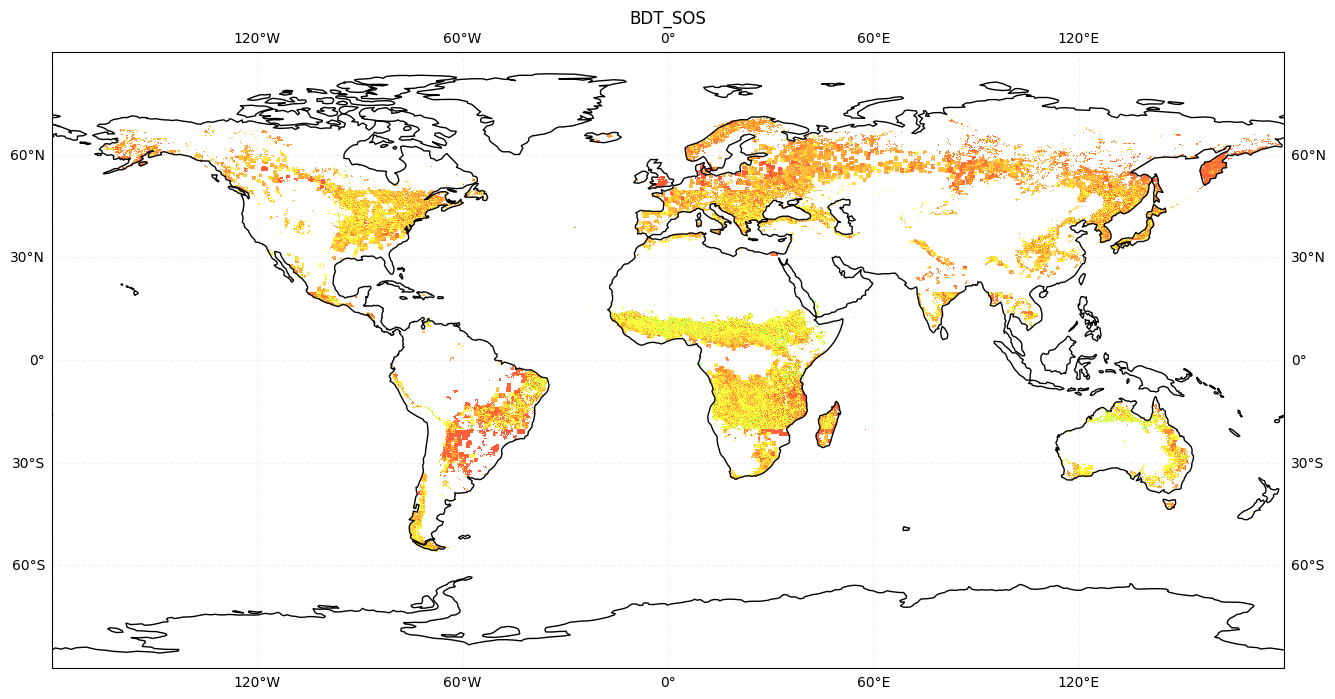

In [80]:
def plot_map_robinson(rgb_list, output_path, title=None):
    # Ensure the rgb_list contains exactly 3 elements (R, G, B channels)
    if len(rgb_list) != 3:
        raise ValueError(
            "rgb_list must contain exactly 3 elements corresponding to R, G, B channels."
        )

    # Stack the RGB channels along the last axis to form an RGB image
    rgb_data = np.stack(rgb_list, axis=-1)

    # Verify the shape of the RGB data (should be 2D grid with 3 color channels)
    if rgb_data.ndim != 3 or rgb_data.shape[-1] != 3:
        raise ValueError("Stacked RGB data should have a shape of (height, width, 3).")

    # Define latitude and longitude values for ticks
    latitudes = np.linspace(90.0, -90.0, rgb_data.shape[0])  # Match the grid shape
    longitudes = np.linspace(-180.0, 180.0, rgb_data.shape[1])  # Match the grid shape

    # Create a new figure and plot
    plt.figure(figsize=(16, 8))

    # Create a Cartopy projection using Robinson projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot coastlines for reference
    ax.coastlines()

    # Add gridlines
    ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.1)
    if title is not None:
        plt.title(title)
    # Plot the RGB data using the `transform` argument for the PlateCarree projection
    im = ax.imshow(
        rgb_data,
        extent=[-180, 180, -90, 90],
        origin="upper",
        transform=ccrs.PlateCarree(),
        interpolation="none",
    )
    ax.set_extent([-179.999, 179.999, -60, 90.0], crs=ccrs.PlateCarree())

    # Display the plot
    # plt.savefig(output_path+title+".png")
    plt.show()


plot_map_robinson(rgb_list, output_path, "BDT_SOS")

In [47]:
len(r2[0])

620

In [6]:
ls "/burg-archive/home/al4385/code/phenology_analysis/drivers_data/"

BDT_-20_20_20250714_EOS.csv      BDT_50_90_20250718_SOS.csv
BDT_-20_20_20250714_SOS.csv      BDT_EOS.png
BDT_-20_20_20250716_EOS.csv      BDT_SOS.png
BDT_-20_20_20250716_SOS.csv      BET_20250714_EOS.csv
BDT_-20_20_20250718_EOS.csv      BET_20250714_SOS.csv
BDT_-20_20_20250718_EOS_rad.csv  BET_20250715_EOS.csv
BDT_-20_20_20250718_SOS.csv      BET_20250715_SOS.csv
BDT_-20_20_20250718_SOS_rad.csv  BET_20250716_EOS.csv
BDT_2020_EOS.png                 BET_20250716_SOS.csv
BDT_-20_-60_20250714_EOS.csv     BET_20250718_EOS.csv
BDT_-20_-60_20250714_SOS.csv     BET_20250718_EOS_rad.csv
BDT_-20_-60_20250716_EOS.csv     BET_20250718_SOS.csv
BDT_-20_-60_20250716_SOS.csv     BET_20250718_SOS_rad.csv
BDT_-20_-60_20250718_EOS.csv     BET_20250722_EOS_days.csv
BDT_-20_-60_20250718_SOS.csv     BET_20250722_SOS_.csv
BDT_2060_EOS.png                 bet_eos.png
BDT_50_20_20250714_EOS.csv       bet_sos.png
BDT_50_20_20250714_SOS.csv       BET_SOS.png
BDT_50_20_20250716_EOS.csv       NDT_20250714_EOS.csv

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


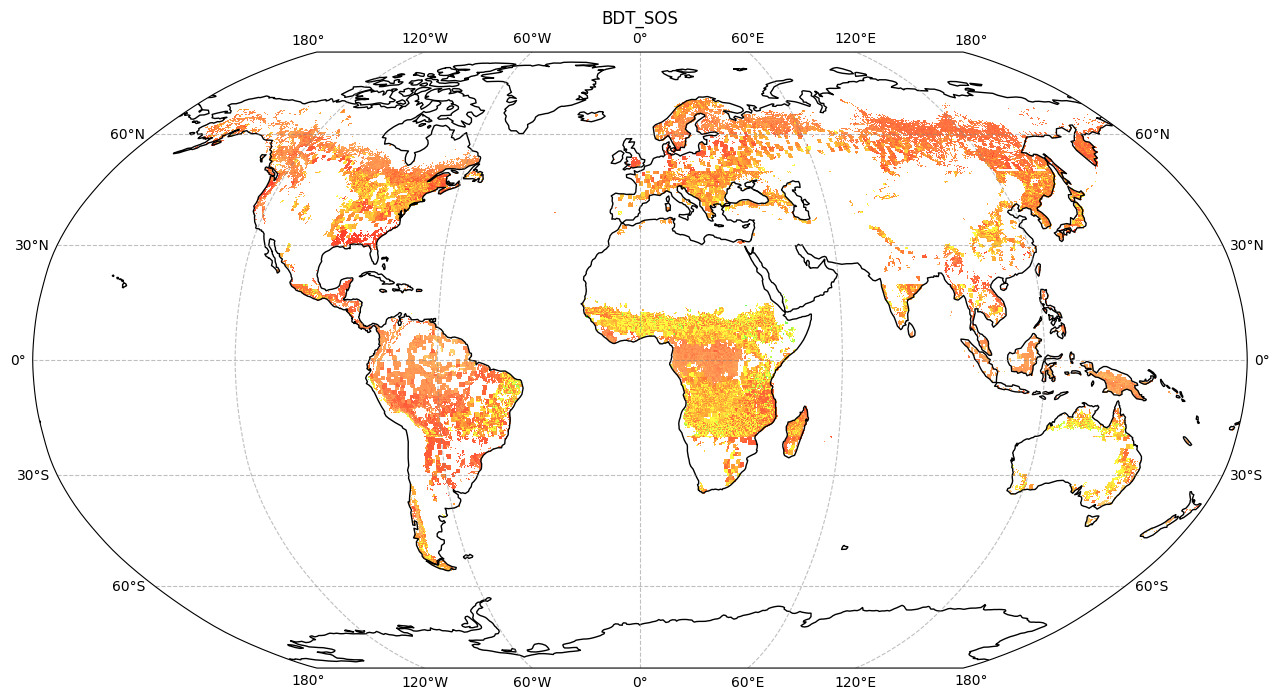

In [4]:
full = concatenate(
    [BDT_5020_SOS, BDT_2020_SOS, BDT_2060_SOS, BDT_5090_SOS, BET_SOS, NDT_SOS, NET_SOS]
)
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_SOS")

In [22]:
### Get SOS Map
BDT_5020_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_50_20_20250718_SOS.csv"
)
BDT_5020_SOS = BDT_5020_SOS[BDT_5020_SOS["latitude"] < 50]

BDT_2020_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_-20_20_20250718_SOS_rad.csv"
)

BDT_2060_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_-20_-60_20250718_SOS.csv"
)

BDT_5090_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_50_90_20250718_SOS.csv"
)
BDT_5020_SOS = BDT_5020_SOS[BDT_5020_SOS["latitude"] < 75]

BET_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BET_20250718_SOS_rad.csv"
)
BET_SOS = BET_SOS[BET_SOS["latitude"] < 30]

NDT_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/NDT_20250714_SOS.csv"
)
NDT_SOS = NDT_SOS[NDT_SOS["latitude"] < 75]

NET_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/NET_20250714_SOS.csv"
)
NET_SOS = NET_SOS[NET_SOS["latitude"] < 75]

In [24]:
full

latitude  longitude  Unnamed: 0  location  hist_tmin  hist_tmax  \
0           90.00    -180.00         NaN       NaN        NaN        NaN   
1           90.00    -179.75         NaN       NaN        NaN        NaN   
2           90.00    -179.50         NaN       NaN        NaN        NaN   
3           90.00    -179.25         NaN       NaN        NaN        NaN   
4           90.00    -179.00         NaN       NaN        NaN        NaN   
...           ...        ...         ...       ...        ...        ...   
1036795    -89.75     178.75         NaN       NaN        NaN        NaN   
1036796    -89.75     179.00         NaN       NaN        NaN        NaN   
1036797    -89.75     179.25         NaN       NaN        NaN        NaN   
1036798    -89.75     179.50         NaN       NaN        NaN        NaN   
1036799    -89.75     179.75         NaN       NaN        NaN        NaN   

         hist_rad  hist_precip  hist_photo  hist_sm  hist_temp  hist_sol  \
0             NaN          NaN         NaN      NaN        NaN       NaN   
1             NaN          NaN         NaN      NaN        NaN       NaN   
2             NaN          NaN         NaN      NaN        NaN       NaN   
3             NaN          NaN         NaN      NaN        NaN       NaN   
4             NaN          NaN         NaN      NaN        NaN       NaN   
...           ...          ...         ...      ...        ...       ...   
1036795       NaN          NaN         NaN      NaN        NaN       NaN   
1036796       NaN          NaN         NaN      NaN        NaN       NaN   
1036797       NaN          NaN         NaN      NaN        NaN       NaN   
1036798       NaN          NaN         NaN      NaN        NaN       NaN   
1036799       NaN          NaN         NaN      NaN        NaN       NaN   

         hist_p  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
1036795     NaN  
1036796     NaN  
1036797     NaN  
1036798     NaN  
1036799     NaN  

[1036800 rows x 13 columns]

In [26]:
full_imp = impute_nearby(full)

In [ ]:
full_imp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


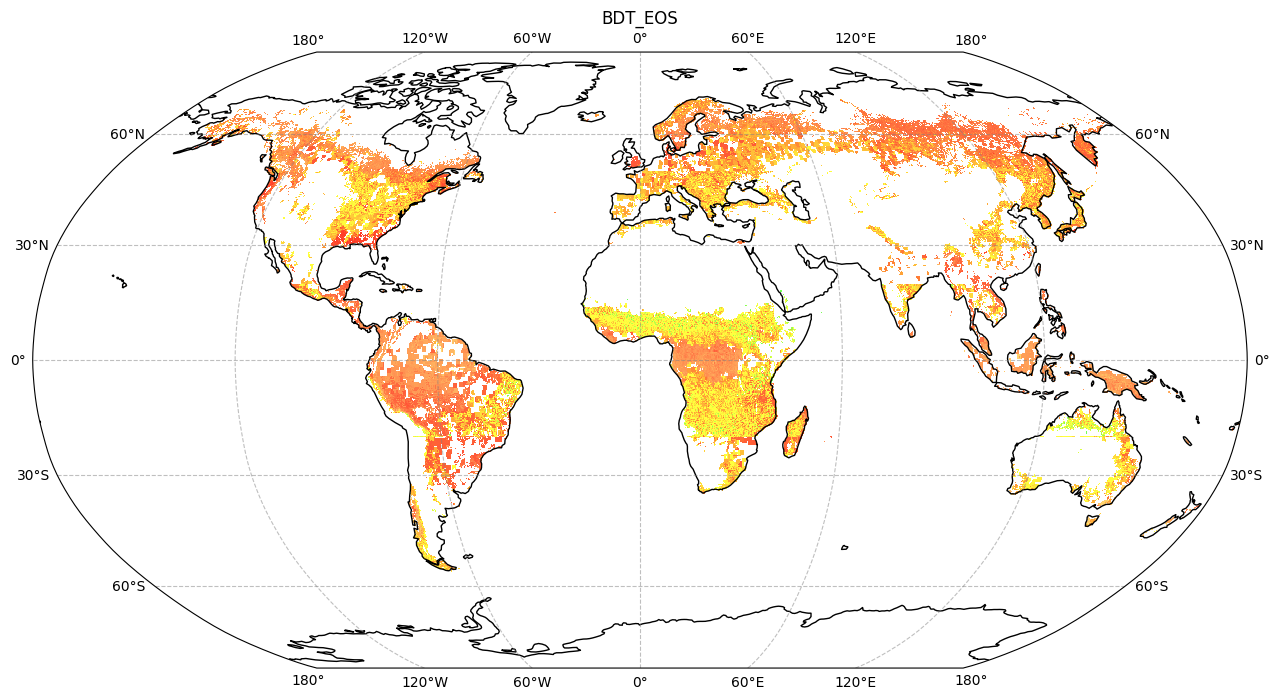

In [23]:
full = concatenate(
    [BDT_5020_SOS, BDT_2020_SOS, BDT_2060_SOS, BDT_5090_SOS, NET_SOS, BET_SOS, NDT_SOS]
)
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_EOS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


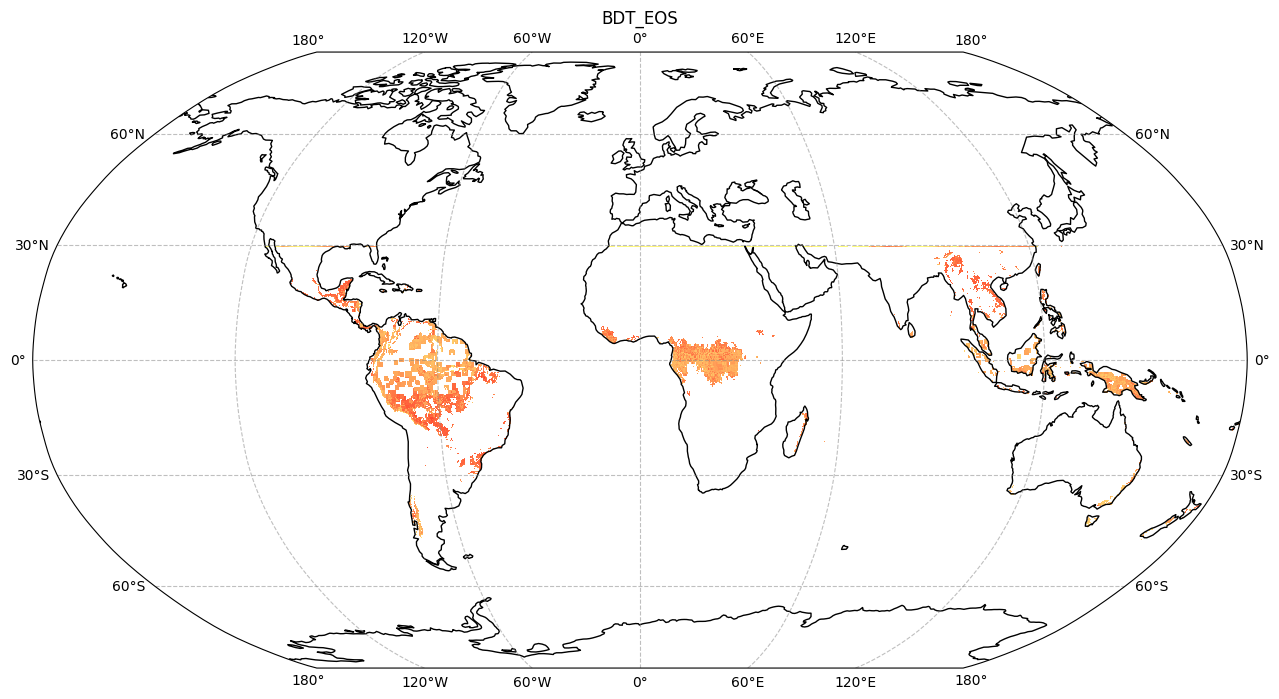

In [15]:
BET_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BET_20250718_EOS_rad.csv"
)
full = concatenate([BET_SOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_EOS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


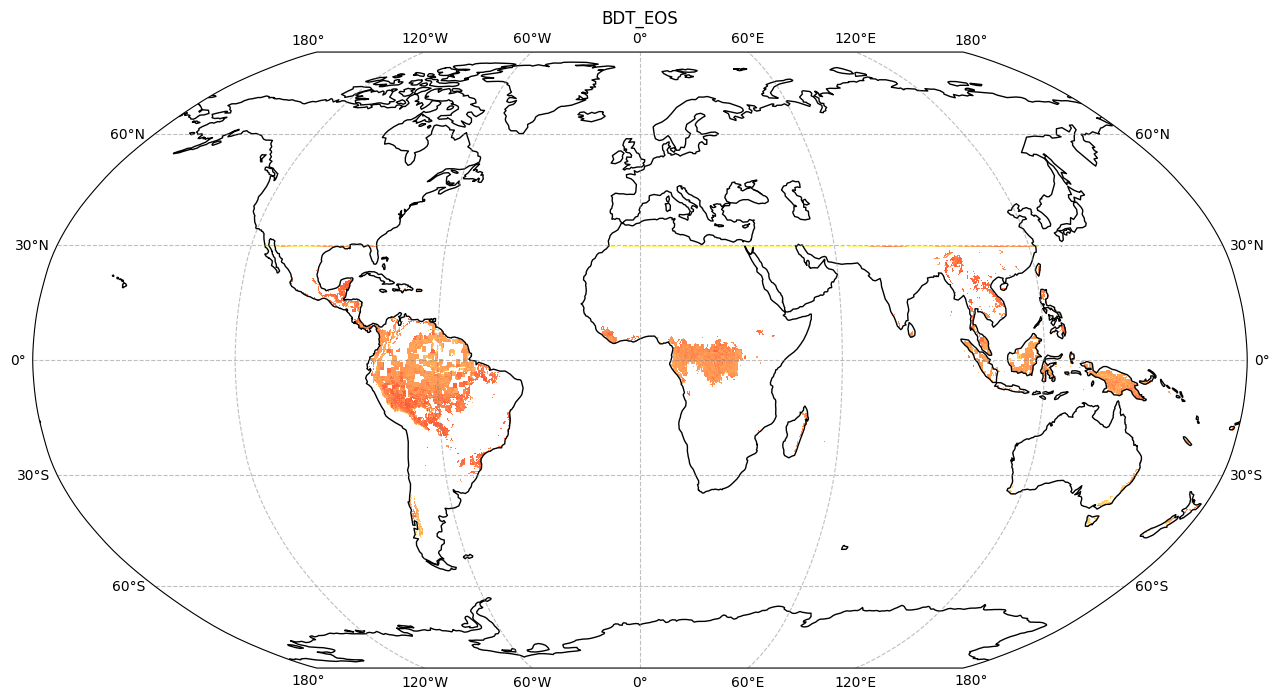

In [14]:
BET_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BET_20250718_SOS_rad.csv"
)
full = concatenate([BET_SOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_EOS")

In [11]:
BDT_2020_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_-20_20_20250718_SOS_rad.csv"
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


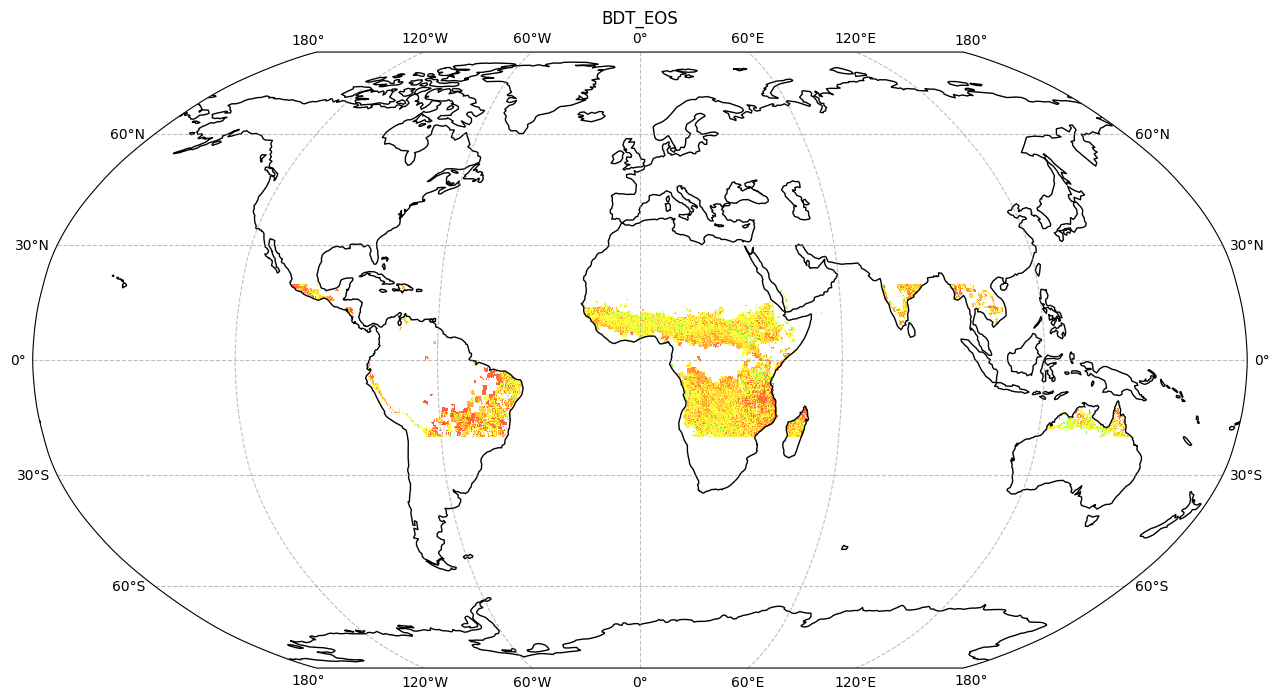

In [12]:
full = concatenate([BDT_2020_SOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_EOS")

In [9]:
BDT_2020_SOS = pd.read_csv(
    "/burg/home/al4385/code/phenology_analysis/drivers_data/BDT_-20_20_20250718_EOS_rad.csv"
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


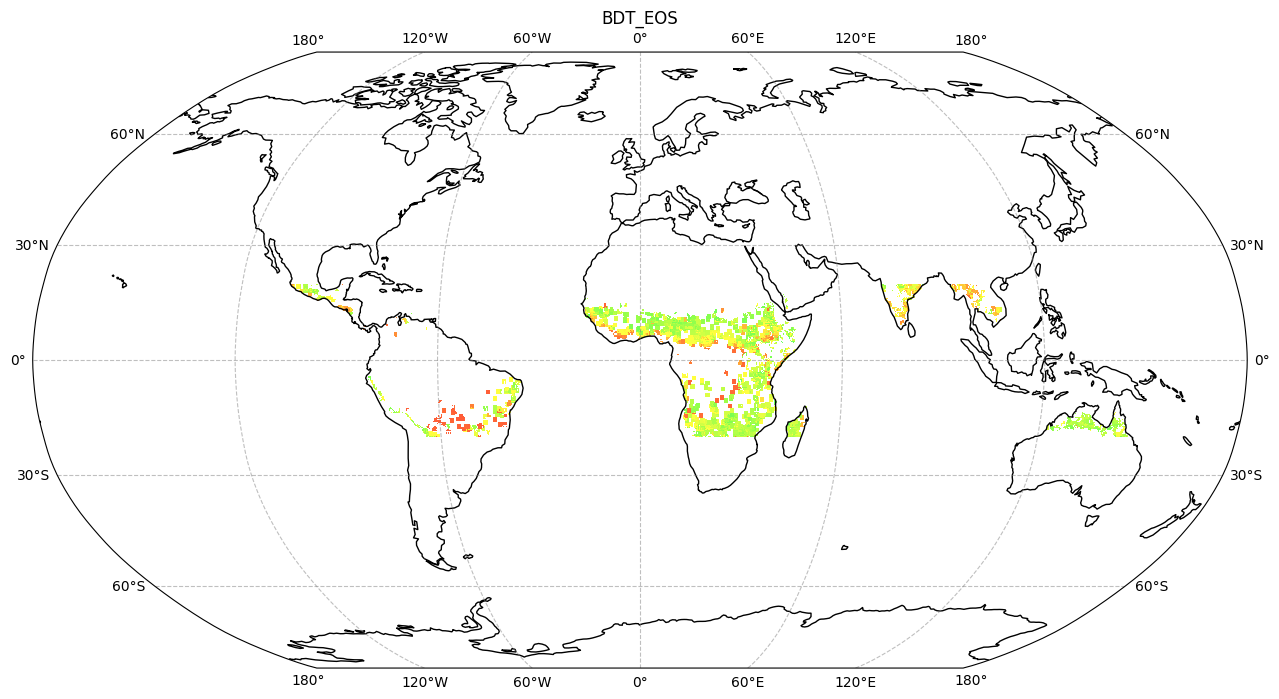

In [10]:
full = concatenate([BDT_2020_SOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_EOS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


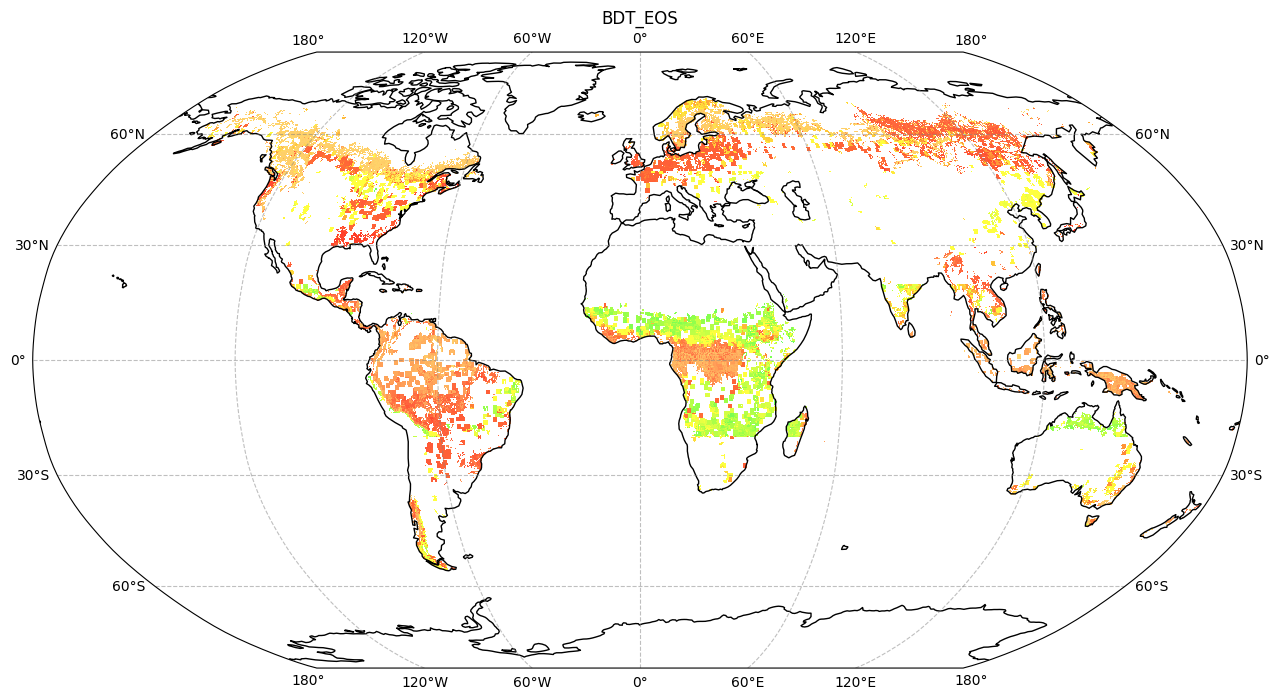

In [19]:
full = concatenate(
    [BDT_5020_SOS, BDT_2020_SOS, BDT_2060_SOS, BDT_5090_SOS, NET_SOS, BET_SOS, NDT_SOS]
)
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_EOS")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


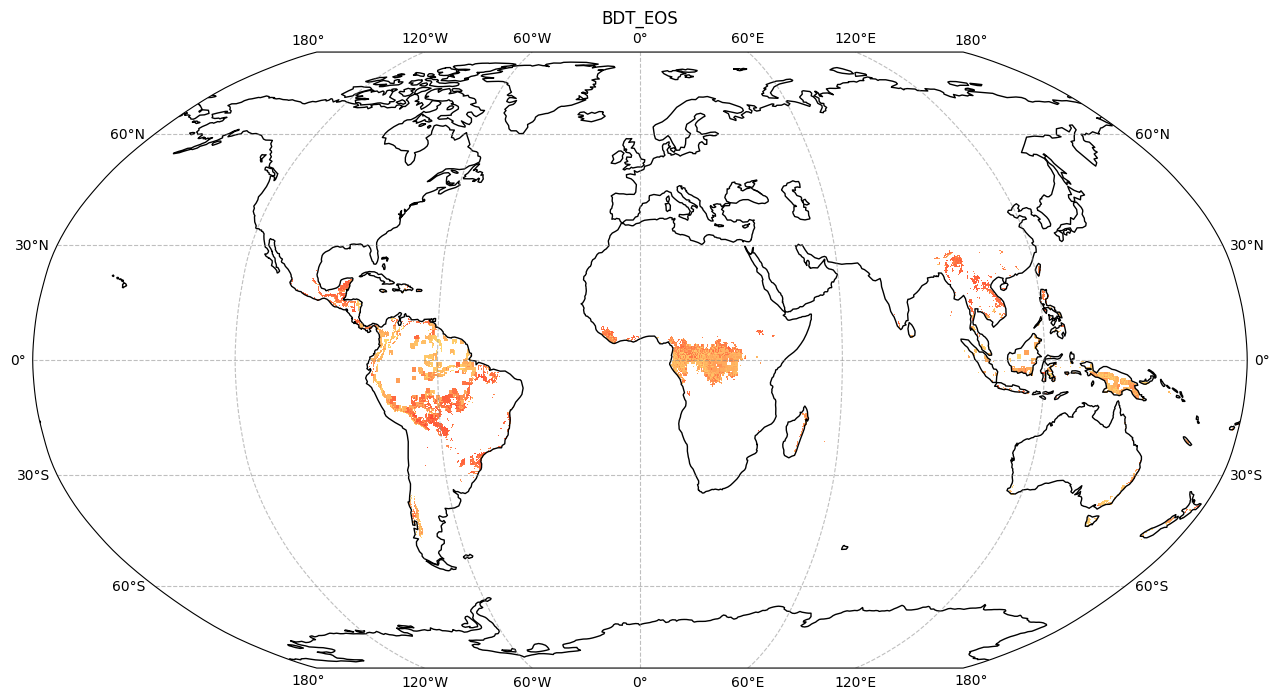

In [8]:
full = concatenate([BET_SOS])
rgb_list = colorize(full)
output_path = "/burg/home/al4385/code/phenology_analysis/drivers_data/"
plot_map_robinson(rgb_list, output_path, "BDT_EOS")

In [ ]:
def concatenate(df_list):
    # Group by latitude, longitude (can have points for many years).
    df = pd.concat(df_list, ignore_index=True)
    grouped_df = df.groupby(["latitude", "longitude"]).mean().reset_index()

    hist_temp = grouped_df["hist_tmin"] + grouped_df["hist_tmax"]
    hist_sol = grouped_df["hist_rad"] + grouped_df["hist_photo"]
    hist_p = grouped_df["hist_precip"] + grouped_df["hist_sm"]

    grouped_df["hist_temp"] = hist_temp
    grouped_df["hist_sol"] = hist_sol
    grouped_df["hist_p"] = hist_p

    # Columns to normalize
    columns_to_normalize = ["hist_temp", "hist_sol", "hist_p"]

    # Normalize the selected columns
    df_normalized = grouped_df[columns_to_normalize].div(
        grouped_df[columns_to_normalize].sum(axis=1), axis=0
    )

    grouped_df["hist_temp"] = df_normalized["hist_temp"]
    grouped_df["hist_sol"] = df_normalized["hist_sol"]
    grouped_df["hist_p"] = df_normalized["hist_p"]

    desired_lat_values = np.linspace(90.0, -89.75, 720)
    desired_lon_values = np.linspace(-180.0, 179.75, 1440)
    # Generate all combinations of values
    combinations = list(product(desired_lat_values, desired_lon_values))
    # Create a DataFrame from the combinations
    df_fullcoord = pd.DataFrame(combinations, columns=["latitude", "longitude"])
    full = pd.merge(df_fullcoord, grouped_df, on=["latitude", "longitude"], how="left")

    return full